<a href="https://colab.research.google.com/github/nv-hiep/dust_scattering/blob/main/Mie_vs_RG_scattering_with_WD01_sizedist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cross-sections from the RG-Drude and Mie scattering**

*   Step 1: Select grain size distributions (MRN1977 or WD2001) and materials (Silicate or Graphite). **Here I used WD2001**.
*   Step 2: Select Scattering models (Rayleigh-Gans RG, Mie) and Materials for cmi models (complex index of refraction models: Drude, Silicate, Graphite, SmallGraphite).
*   Step 3: Calculate Scattering Cross-Sections, Scattering Opacity.
*   Step 4: Plot


# 1. Mount the google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# !ls

Mounted at /content/gdrive


# 2. Root directory

In [2]:
cd '/content/gdrive/My Drive/Colab Notebooks/dust'

/content/gdrive/My Drive/Colab Notebooks/dust


# 3. Import Libraries



## 3.1 Standard libraries

In [3]:
import os
import numpy   as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline  

## 3.2 Dust libraries

In [4]:
import libs.constants    as c

from libs                import sizedist
from libs.extinction     import scattools

## 4. Set some parameters: dust mass column, energy range, wavelength range

In [5]:
NH     = 1.e21                                # H column density [H cm^-2]
D2G    = 0.009                                # Dust-to-gas ratio
M_dust = NH * c.M_p * D2G                     # Dust mass column [g cm^-2]

E_range    = np.logspace(-0.6, 1., 20)        # KeV, slow
lambda_    = c.HC / E_range                   # [cm]      
lambda_    = lambda_ / c.MICRON2CM            # [micron]
lambda_inv = 1. / lambda_                     # [um^-1]

# 5. Grain size distributions and materials

**Here I used WD2001**.

See Mie_vs_RG_scattering_with_MRN77_sizedist.ipynb for the MRN1977 model

In [6]:
# WD2001 model
WD01_MW_sil_bc6 = sizedist.WD01(bc=6., graintype='Silicate')
WD01_MW_gra_bc6 = sizedist.WD01(bc=6., graintype='Graphite')

# 6. Grain scattering models

Select from:
*   Scattering models: RG, Mie
*   Materials for models odels of the complex index of refraction: Drude, Silicate, Graphite, SmallGraphite

In [7]:
RG_Drude = scattools.create_scat_model('RG','Drude')
Mie_sil  = scattools.create_scat_model('Mie','Silicate')
Mie_gra  = scattools.create_scat_model('Mie','Graphite')

In [8]:
print(RG_Drude.__dict__.keys())
print(type(RG_Drude.scat_model))
print(type(RG_Drude.cmindex_model))

dict_keys(['scat_model', 'cmindex_model', 'scat_type', 'cmindex_type'])
<class 'libs.extinction.scatmodels.RGscat'>
<class 'libs.composition.cmindex.CmDrude'>


# 7. Scattering cross-sections

<!-- $$\kappa = \frac{1}{M_d}\ \int \sigma\ \frac{dn}{da}\ da $$ -->

In [9]:
%%time
RGD_sil_kappa = scattools.KappaScat(E=E_range, dist=WD01_MW_sil_bc6, scatm=RG_Drude)

CPU times: user 14.9 ms, sys: 2.35 ms, total: 17.3 ms
Wall time: 17.2 ms


In [10]:
%%time
RGD_gra_kappa = scattools.KappaScat(E=E_range, dist=WD01_MW_gra_bc6, scatm=RG_Drude)

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 13.4 ms


In [11]:
%%time
Mie_sil_kappa = scattools.KappaScat(E=E_range, dist=WD01_MW_sil_bc6, scatm=Mie_sil)

CPU times: user 3min 4s, sys: 115 ms, total: 3min 4s
Wall time: 3min 4s


In [12]:
%%time
Mie_gra_kappa = scattools.KappaScat(E=E_range, dist=WD01_MW_gra_bc6, scatm=Mie_gra)

CPU times: user 6min 12s, sys: 195 ms, total: 6min 12s
Wall time: 6min 13s


# 8. Plot

M_dust : mass density of dust [in this case : g cm^-2]

nd     : number density of dust [in this case: cm^-2]

rho    : dust grain material density [g cm^-3]




$$\kappa = \frac{1}{M_{dust}}\ \int \sigma_{sca}\ \frac{dn}{da}\ da $$

$$\kappa = \pi a^2 Q_{sca} N_{dust} / M_{dust} = \sigma_{sca} * N_{dust} / M_{dust}$$

$$\kappa = \tau_{sca}/M_{dust}$$

$$M_{dust} = N_H * m_p * d2g$$

Multiply <code>kappa</code> by the dust mass to get the total opacity.

In [13]:
def plot_(ax, obj, **kwargs):

  tau_sca = 1.e21 * obj.kappa * obj.dist.md
  ax.plot(obj.E, tau_sca, **kwargs)

  ax.tick_params(labelsize=15)
  ax.set_xlabel('Energy (keV)', size=15)
  ax.set_ylabel(r'Scattering Opacity ($\tau$)', size=15)

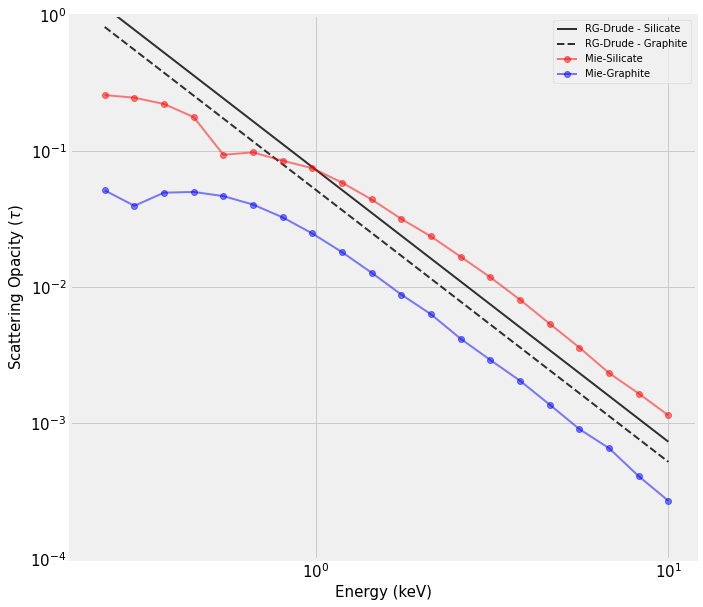

In [14]:
plt.figure( figsize=(10, 10) )
ax = plt.subplot(111)

plot_(ax, RGD_sil_kappa, color='k', lw=2, alpha=0.8, label='RG-Drude - Silicate')
plot_(ax, RGD_gra_kappa, color='k', lw=2, ls='--', alpha=0.8, label='RG-Drude - Graphite')
plot_(ax, Mie_sil_kappa, marker='o', color='r', lw=2, alpha=0.5, label='Mie-Silicate')
plot_(ax, Mie_gra_kappa, marker='o', color='b', lw=2, alpha=0.5, label='Mie-Graphite')
plt.legend(loc='upper right', frameon=False)
plt.loglog()

plt.xlim(0.2, 12.)
plt.ylim(1.e-4, 1.)

plt.legend()
plt.show()